## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from train_utils import train
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

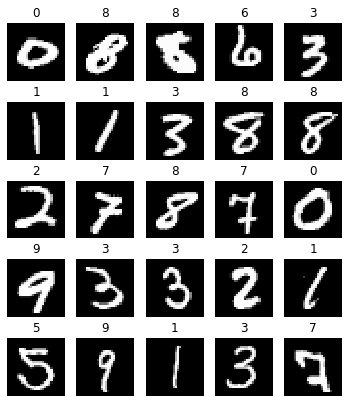

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [7]:
def make_linear(in_dim, out_dim, init_func):
    layer = nn.Linear(in_dim, out_dim)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_func(layer)
    
    return layer

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [8]:
def dumb_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)

    
def xavier_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    d = 2 / (weight.size()[0] + weight.size()[1])
    weight.normal_(mean=0, std=np.sqrt(d))
    
    
def xavier_init_uni(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    r = np.sqrt(6 / (weight.size()[0] + weight.size()[1]))
    weight.uniform_(-r, r)

    
def He_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    d = 2 / weight.size()[0]
    weight.normal_(mean=0, std=np.sqrt(d))

In [9]:
def init_compare(init_f):
    net = []
    net.append(make_linear(28*28, 500, init_f))
    for i in range(8):
        net.append(make_linear(500, 500, init_f))
    net.append(make_linear(500, 10, init_f))
    net = nn.Sequential(*net)

    #пример:
    n_objects = 100
    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data
    activations = net(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()

In [10]:
init_compare(xavier_init_uni)

forward 1.012622594833374
forward 1.1137721538543701
forward 1.1105083227157593
forward 1.0881481170654297
forward 1.0833200216293335
forward 1.1050645112991333
forward 1.1128027439117432
forward 1.0787646770477295
forward 1.0784327983856201
forward 1.0786019563674927
backward 0.03299831226468086
backward 0.021313250064849854
backward 0.02140275575220585
backward 0.022007834166288376
backward 0.022779127582907677
backward 0.023497994989156723
backward 0.023756178095936775
backward 0.02390231192111969
backward 0.02407386712729931
backward 0.023492131382226944


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [11]:
init_compare(xavier_init)

forward 1.012622594833374
forward 1.1216058731079102
forward 1.1154667139053345
forward 1.1253533363342285
forward 1.119664192199707
forward 1.1303664445877075
forward 1.1320425271987915
forward 1.1320945024490356
forward 1.1251075267791748
forward 1.125066876411438
backward 0.03299831226468086
backward 0.020704422146081924
backward 0.02056141570210457
backward 0.021097682416439056
backward 0.020802587270736694
backward 0.021877994760870934
backward 0.021585797891020775
backward 0.022064078599214554
backward 0.02317650057375431
backward 0.021123167127370834


In [12]:
init_compare(He_init)

forward 1.012622594833374
forward 1.802974820137024
forward 2.548560380935669
forward 3.560472249984741
forward 4.967099189758301
forward 7.083099842071533
forward 10.212815284729004
forward 14.34191608428955
forward 20.4102725982666
forward 29.39042854309082
backward 0.03299831226468086
backward 0.14940184354782104
backward 0.22227366268634796
backward 0.3271060883998871
backward 0.4584899842739105
backward 0.6720123291015625
backward 0.9424819350242615
backward 1.3379528522491455
backward 1.8879553079605103
backward 2.5594639778137207


<i> 1.4 Сделайте выводы по первой части </i>

Метод инициализации Завьера (Xavier) (иногда — метод Glorot’а). Основная идея этого метода — упростить прохождение сигнала через слой во время как прямого, так и обратного распространения ошибки для линейной функции активации (этот метод также хорошо работает для сигмоидной функции, так как участок, где она ненасыщена, также имеет линейный характер).

Метод инициализации Ге (He) — это вариация метода Завьера, больше подходящая функции активации ReLU, компенсирующая тот факт, что эта функция возвращает нуль для половины области определения.

В таком случае, становится очевидным, почему инициализация Xavier на нашем примере сработала лучше чем He

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [13]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

    
    
class DropConnect(nn.Module):
    
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()        
        self.lin = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.ones_like(self.lin.weight) * self.p
        
        if self.training:
            mask = torch.ones_like(self.lin.weight) * self.p
            mask.bernoulli_()
            
        mask.detach_()
        output = torch.mm(x, (self.lin.weight*mask).transpose(0, 1))+self.lin.bias
        return output
    
    

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [14]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]): 
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.Dropout(0.5))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.617/0.289	Accuracy: 0.844/0.926


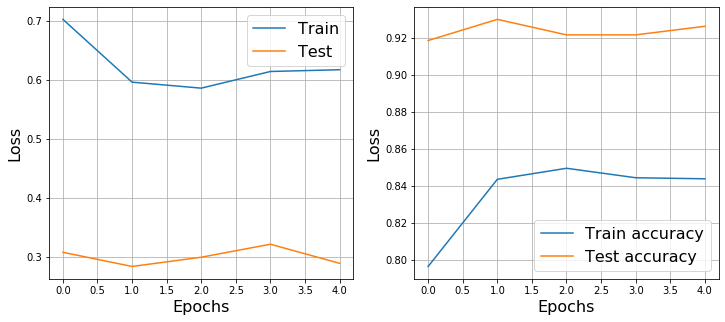

([0.7028762732487498,
  0.5964349934986151,
  0.5862913938727714,
  0.6145263257692618,
  0.617487163431863],
 [0.3080638720642162,
  0.2841111804488339,
  0.2997406260876716,
  0.32177624087544937,
  0.2893870598341845],
 [0.7963142, 0.84351677, 0.84950244, 0.84437186, 0.8438055],
 [0.9187105, 0.930182, 0.9217761, 0.9217761, 0.926424])

In [16]:
train(net, train_loader, test_loader, 5, 0.01, device='cpu')

In [18]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]): 
    net.append(DropConnect(in_dim, out_dim, p=0.5))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.261/0.146	Accuracy: 0.931/0.961


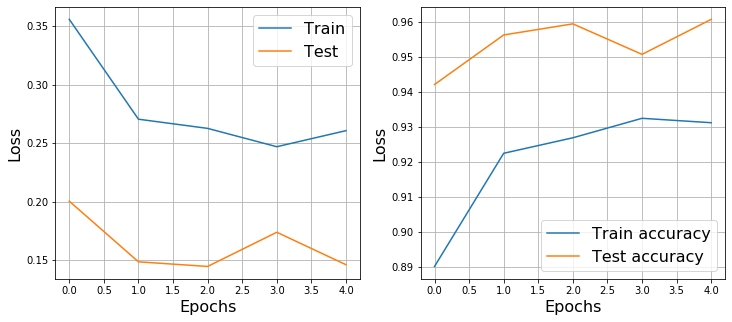

([0.35584158582219694,
  0.270442005620201,
  0.2625891863982052,
  0.24691378221964277,
  0.26064901872039603],
 [0.20032434957691386,
  0.14846991327933118,
  0.14451359924447688,
  0.17375856600230252,
  0.14599195881923543],
 [0.89015305, 0.9224358, 0.9268557, 0.9324138, 0.93115336],
 [0.942049, 0.95619065, 0.95935524, 0.9506527, 0.96064085])

In [19]:
train(net, train_loader, test_loader, 5, 0.01, device='cpu')

<i> 2.3 Сделайте выводы по третьей части. Отобразите кривые обучения на одном графике </i>

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [91]:
class LayerNormalization(nn.Module):
    def forward(self, x):
        output = (x - x.mean(1).repeat(x.size()[1], 1).T) / x.std(1).repeat(x.size()[1], 1).T
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [100]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]): 
    net.append(nn.BatchNorm1d(num_features=in_dim))
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.ReLU())

net.append(nn.BatchNorm1d(num_features=sizes[-1]))
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))

net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.017/0.200	Accuracy: 0.994/0.977


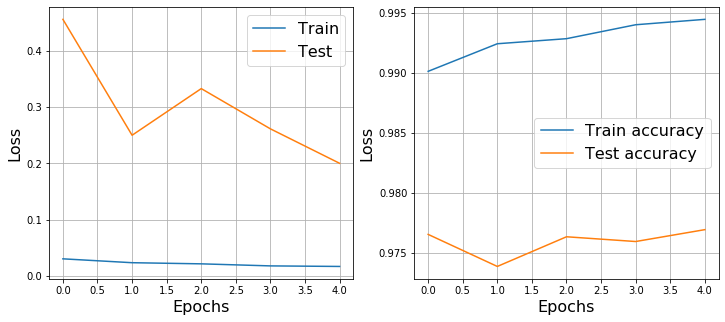

([0.030181389522931375,
  0.023294103029345387,
  0.02127027517225075,
  0.017616712572411753,
  0.01664049380891043],
 [0.4560067842643479,
  0.24993836282622778,
  0.33287780526716004,
  0.26128735218220683,
  0.20004222098195665],
 [0.99014974, 0.9924485, 0.99287045, 0.994031, 0.9944807],
 [0.9765625, 0.9738924, 0.97636473, 0.97596914, 0.9769581])

In [102]:
train(net, train_loader, test_loader, 5, 0.005, device='cpu')

In [93]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]): 
    net.append(nn.Linear(in_dim, out_dim))
    net.append(LayerNormalization())
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(LayerNormalization())
net.append(nn.LogSoftmax(1))

net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.374/0.389	Accuracy: 0.983/0.976


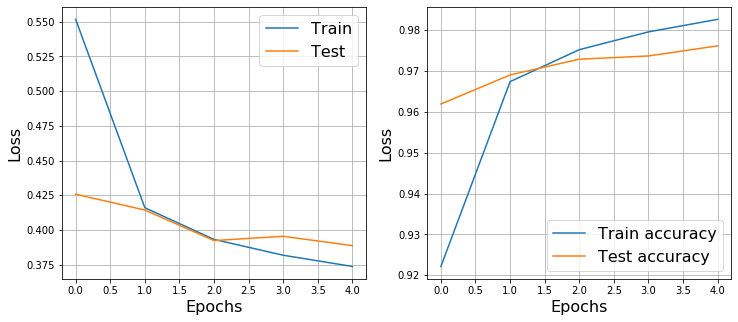

([0.5516414341133541,
  0.4160048373218284,
  0.39319733280871216,
  0.3818014715907416,
  0.3737267304076823],
 [0.42573569620711893,
  0.4143414323842978,
  0.3923725451849684,
  0.39543495940256723,
  0.38872854015495206],
 [0.9221582, 0.9674063, 0.97522986, 0.9795887, 0.9826592],
 [0.9619264, 0.96904665, 0.9729035, 0.9736946, 0.9761669])

In [94]:
train(net, train_loader, test_loader, 5, 0.01, device='cpu')

<i> 3.3 Сделайте выводы по третьей части </i>

Добавление слоёв LayerNormalization() и BatchNorm1d() позитивно сказывается на сходимости сетей
и приводит данные на тесте к виду более близкому к данным для обучения, чем увеличивает точность и 
снижает ошибку

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: